In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
print(tf. __version__)

from SQ_decoder import SQ_decoder, to_tf

2.5.0


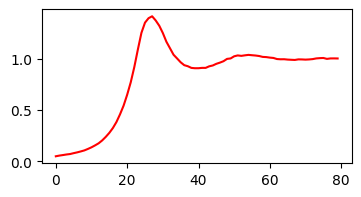

In [2]:
z_example = to_tf([0.159027  ,  0.14598719,  0.4])
SQ_example = SQ_decoder(z_example)
fig = plt.figure(figsize=(4, 2))
ax = plt.subplot(1,1,1)
ax.plot(SQ_example,'-r')
plt.show()

In [3]:
# define class VAE
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, sq_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        regularizer = None
        self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(sq_dim)),
            tf.keras.layers.Reshape((sq_dim,1)),
            tf.keras.layers.Conv1D(
                filters=32, kernel_size=3, strides=2, activation='relu',
                kernel_regularizer = regularizer,
                name='conv1d_en'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(
                latent_dim + latent_dim, 
                kernel_regularizer = regularizer,
                name='dense_en'),
        ]
        )
        
        self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(
                40*32, activation=tf.nn.relu, 
                kernel_regularizer = regularizer,
                name='dense_de'),
            tf.keras.layers.Reshape(target_shape=(40, 32)),
            tf.keras.layers.Conv1DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same', activation='relu',
                kernel_regularizer = regularizer,
                name='conv1dtrs_de'),
            tf.keras.layers.Conv1DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
            tf.keras.layers.Reshape((sq_dim,))
        ]
        )
        
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = 0*tf.random.normal(shape=(1000, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
        
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [4]:
# load pre-trained decoder
@tf.function
def f_out_tf(predictions):
    return tf.math.exp((predictions*2-1)*exp_scale)

latent_dim = 3
q_rs_dim = 80
model = VAE(latent_dim, q_rs_dim)

export_path = './saved_model/SQ_cVAE_MSE_ns/'
model_name = 'model_conv_stride2_exp6'
export_name = export_path + model_name

reload_sm = model.load_weights(export_name, by_name=False, skip_mismatch=False, options=None)
model_r = reload_sm._root
decoder_loaded = model_r.decoder
decoder_loaded.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_de (Dense)             (None, 1280)              5120      
_________________________________________________________________
reshape_4 (Reshape)          (None, 40, 32)            0         
_________________________________________________________________
conv1dtrs_de (Conv1DTranspos (None, 80, 32)            3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 80, 1)             97        
_________________________________________________________________
reshape_5 (Reshape)          (None, 80)                0         
Total params: 8,321
Trainable params: 8,321
Non-trainable params: 0
_________________________________________________________________


In [5]:
# Add a dense layer to pre-trained decoder
regularizer = None
dense_3 = [
    tf.keras.layers.InputLayer(input_shape=(3)),
    tf.keras.layers.Dense(3, activation=tf.nn.relu, 
                kernel_regularizer = regularizer,
                name='dense_in')]

decoder_aug_layers = dense_3+decoder_loaded.layers
decoder_aug = tf.keras.Sequential(decoder_aug_layers)
decoder_aug.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_in (Dense)             (None, 3)                 12        
_________________________________________________________________
dense_de (Dense)             (None, 1280)              5120      
_________________________________________________________________
reshape_4 (Reshape)          (None, 40, 32)            0         
_________________________________________________________________
conv1dtrs_de (Conv1DTranspos (None, 80, 32)            3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 80, 1)             97        
_________________________________________________________________
reshape_5 (Reshape)          (None, 80)                0         
Total params: 8,333
Trainable params: 8,333
Non-trainable params: 0
____________________________________________________

In [6]:
# Freeze trainable
for i, layers in enumerate(decoder_aug.layers):
    if i>0:
        decoder_aug.layers[i].trainable = False

decoder_aug.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_in (Dense)             (None, 3)                 12        
_________________________________________________________________
dense_de (Dense)             (None, 1280)              5120      
_________________________________________________________________
reshape_4 (Reshape)          (None, 40, 32)            0         
_________________________________________________________________
conv1dtrs_de (Conv1DTranspos (None, 80, 32)            3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 80, 1)             97        
_________________________________________________________________
reshape_5 (Reshape)          (None, 80)                0         
Total params: 8,333
Trainable params: 12
Non-trainable params: 8,321
___________________________________________________